In [ ]:
from ase.io import read
import numpy as np
from matplotlib import pyplot as plt
import joblib, pickle, sys
sys.path.insert(0,"../")
from castle import train_ensamble_linear_model, train_linear_model, ASEMLCalculator, AceGlobalRepresentation, AceLocalRepresentation
from castle import get_forces_and_energies, get_virials, get_nat, dump, load, print_score, utils

%load_ext autoreload
%autoreload 2

In [84]:
# folder = "/home/claudio/postdoc/data/Au_13/"


# species = 'Au'
# N = 5
# maxdeg = 8
# rcut = 5.0
# temp = 400

# tr_features = utils.extract_local_features(folder,  f"planar_{temp}K.xyz",
#                                              N=N, maxdeg=maxdeg, rcut=rcut, force_name = 'force', energy_name = 'energy',
#                                             species = species)
# np.save(folder + f"planar_{temp}K_local_features_N_{N}_d_{maxdeg}.npy", np.concatenate(tr_features.X))
# print(np.concatenate(tr_features.X).shape)

(13000, 77)


In [29]:
root = "/home/claudio/postdoc/data/Si_gabor/"

N = 4
maxdeg = 8
rcut = 4.5
noise = 1e-8

force_name = 'dft_force'
energy_name = 'dft_energy'

# tr_features = utils.extract_features(root , "train.xyz", "test.xyz",
#                                              N=N, maxdeg=maxdeg, rcut=rcut, force_name = force_name, energy_name = energy_name,
#                                             species = 14)

e_t, f_t, e_val, f_val, nat_tr, nat_val, tr_features, val_features = utils.load_everything(
    root, "train.xyz", "test.xyz",
    f"tr_features_N_{N}_d_{maxdeg}.xz", f"val_features_N_{N}_d_{maxdeg}.xz", force_name = force_name, energy_name = energy_name)

In [30]:
model = train_linear_model(tr_features, noise, e_t, f_t)
ep_l, fp_l = model.predict(val_features)
en_errs_lin_si = ep_l/nat_val - e_val/nat_val
force_errs_lin_si = fp_l.flatten() - f_val.flatten()

model =  train_ensamble_linear_model(tr_features, noise, e_t, f_t,
                    n_neighbours=1, 
                     n_clusters=40, clustering='e_gmm')
ep_e1, fp_e1 = model.predict(val_features)

en_errs_ens1_si = ep_e1/nat_val - e_val/nat_val
force_errs_ens1_si = fp_e1.flatten() - f_val.flatten()

model =  train_ensamble_linear_model(tr_features, noise, e_t, f_t,
                    n_neighbours=4, 
                     n_clusters=40, clustering='e_gmm')
ep_e10, fp_e10 = model.predict(val_features)

en_errs_ens10_si = ep_e10/nat_val - e_val/nat_val
force_errs_ens10_si = fp_e10.flatten() - f_val.flatten()

In [32]:
import pandas as pd
df_l = pd.DataFrame()
df_l['diff'] = ep_l/nat_val - e_val/nat_val
df_l['mae'] = abs(df_l['diff'])
df_l['model'] = 'lin'

df_e1 = pd.DataFrame()
df_e1['diff'] = ep_e1/nat_val - e_val/nat_val
df_e1['mae'] = abs(df_e1['diff'])
df_e1['model'] = 'ens1'

df_e10 = pd.DataFrame()
df_e10['diff'] = ep_e10/nat_val - e_val/nat_val
df_e10['mae'] = abs(df_e10['diff'])
df_e10['model'] = 'ens10'

df_en_si = pd.concat([df_l, df_e1, df_e10])


df_l = pd.DataFrame()
df_l['diff'] = fp_l.flatten() - f_val.flatten()
df_l['mae'] = abs(df_l['diff'])
df_l['model'] = 'lin'

df_e1 = pd.DataFrame()
df_e1['diff'] = fp_e1.flatten() - f_val.flatten()
df_e1['mae'] = abs(df_e1['diff'])
df_e1['model'] = 'ens1'

df_e10 = pd.DataFrame()
df_e10['diff'] = fp_e10.flatten() - f_val.flatten()
df_e10['mae'] = abs(df_e10['diff'])
df_e10['model'] = 'ens10'

df_f_si = pd.concat([df_l, df_e1, df_e10])

In [37]:
df_f_si.groupby(by='model').mean()

,diff,mae
model,,
ens1,-1.750118e-08,0.235493
ens10,-1.750118e-08,0.239809
lin,-1.750117e-08,0.974803


In [39]:
df_en_si.groupby(by='model').mean()

,diff,mae
model,,
ens1,-0.002076,0.016628
ens10,-0.002081,0.017177
lin,0.371225,0.529356


No handles with labels found to put in legend.


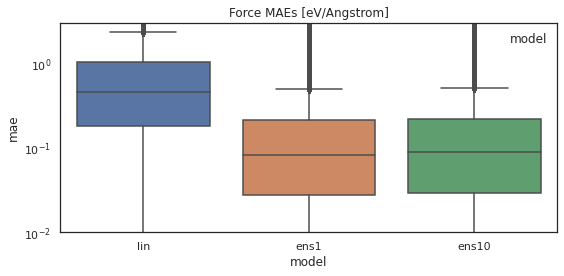

In [199]:
plt.figure(figsize = (8, 4))
sns.boxplot(data = df_f_si, y = 'mae', x = 'model')
plt.yscale('log')
plt.ylim(1e-2, 3)
plt.legend(frameon=False, bbox_to_anchor = (1, 1), title = 'model')
plt.title('Force MAEs [eV/Angstrom]')
plt.tight_layout()
plt.savefig("/home/claudio/postdoc/plots/si_ensamble_force_maes.pdf")

No handles with labels found to put in legend.


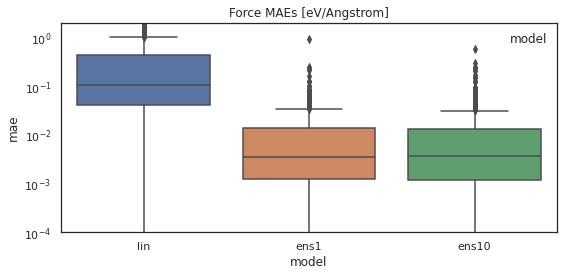

In [200]:
plt.figure(figsize = (8, 4))
sns.boxplot(data = df_en_si, y = 'mae', x = 'model')
plt.yscale('log')
plt.ylim(1e-4, 2)
plt.legend(frameon=False, bbox_to_anchor = (1, 1), title = 'model')
plt.title('Force MAEs [eV/Angstrom]')
plt.tight_layout()
plt.savefig("/home/claudio/postdoc/plots/si_ensamble_energy_maes.pdf")

In [22]:
rcuts = {'Cu': 3.9, 'Mo': 5.2, 'Si': 4.7, 'Ge':5.1, 'Ni':4.0, 'Li':5.1}
root = "/home/claudio/postdoc/data/Zuo/"

species = 'Mo'
N = 4
maxdeg = 8
rcut = rcuts[species]
force_name = 'dft_forces'
energy_name = 'DFT_PE'

# tr_features, val_features = utils.extract_features(root + f"{species}/", "train_trajectory.xyz", "validation_trajectory.xyz",
#                                              N=N, maxdeg=maxdeg, rcut=rcut, force_name = force_name, energy_name = energy_name,
#                                             species = species)

e_t, f_t, e_val, f_val, nat_tr, nat_val, tr_features, val_features = utils.load_everything(
    root + f"{species}/", "train_trajectory.xyz", "validation_trajectory.xyz",
    f"tr_features_N_{N}_d_{maxdeg}.xz", f"val_features_N_{N}_d_{maxdeg}.xz", force_name = force_name)

In [70]:
for species in rcuts.keys():
    tr_features, val_features = utils.extract_features(root + f"{species}/", "train_trajectory.xyz", "validation_trajectory.xyz",
                                             N=N, maxdeg=maxdeg, rcut=rcut, force_name = force_name, energy_name = energy_name,
                                            species = species)
    # e_t, f_t, e_val, f_val, nat_tr, nat_val, tr_features, val_features = utils.load_everything(
    #     root + f"{species}/", "train_trajectory.xyz", "validation_trajectory.xyz",
    #     f"tr_features_N_{N}_d_{maxdeg}.xz", f"val_features_N_{N}_d_{maxdeg}.xz", force_name = force_name)

In [71]:
en_errs_lin = {}
force_errs_lin = {}
en_errs_ens1 = {}
force_errs_ens1 = {}
en_errs_ens10 = {}
force_errs_ens10 = {}
for species in rcuts.keys():
    print(species)
    e_t, f_t, e_val, f_val, nat_tr, nat_val, tr_features, val_features = utils.load_everything(
        root + f"{species}/", "train_trajectory.xyz", "validation_trajectory.xyz",
        f"tr_features_N_{N}_d_{maxdeg}.xz", f"val_features_N_{N}_d_{maxdeg}.xz", force_name = force_name)
    
    model = train_linear_model(tr_features, noise, e_t, f_t)
    ep = model.predict_energy(val_features)
    fp = model.predict_forces(val_features)
    en_errs_lin[species] = ep/nat_val - e_val/nat_val
    force_errs_lin[species] = fp.flatten() - f_val.flatten()
    
    model =  train_ensamble_linear_model(tr_features, noise, e_t, f_t,
                        n_neighbours=1, 
                         n_clusters=8, clustering='e_gmm')
    ep = model.predict_energy(val_features)
    fp = model.predict_forces(val_features)
    en_errs_ens1[species] = ep/nat_val - e_val/nat_val
    force_errs_ens1[species] = fp.flatten() - f_val.flatten()
    
    model =  train_ensamble_linear_model(tr_features, noise, e_t, f_t,
                        n_neighbours=10, 
                         n_clusters=8, clustering='e_gmm')
    ep = model.predict_energy(val_features)
    fp = model.predict_forces(val_features)
    en_errs_ens10[species] = ep/nat_val - e_val/nat_val
    force_errs_ens10[species] = fp.flatten() - f_val.flatten()

Cu
Mo
Si
Ge
Ni
Li


In [85]:
import pandas as pd
df_f = pd.DataFrame()
df_en = pd.DataFrame()

for s in rcuts.keys():
    df1 = pd.DataFrame.from_dict(en_errs_lin[s])
    df1['model'] = 'lin'
    df2 = pd.DataFrame.from_dict(en_errs_ens1[s])
    df2['model'] = 'ens1'
    df3 = pd.DataFrame.from_dict(en_errs_ens10[s])
    df3['model'] = 'ens10'
    df = pd.concat([df1, df2, df3])
    df = df.rename(columns = {0:'diff'})
    df['mae'] = abs(df['diff'])
    df['species'] = s
    df_en = df_en.append(df)

    df1 = pd.DataFrame.from_dict(force_errs_lin[s])
    df1['model'] = 'lin'
    df2 = pd.DataFrame.from_dict(force_errs_ens1[s])
    df2['model'] = 'ens1'
    df3 = pd.DataFrame.from_dict(force_errs_ens10[s])
    df3['model'] = 'ens10'
    df = pd.concat([df1, df2, df3])
    df = df.rename(columns = {0:'diff'})
    df['mae'] = abs(df['diff'])
    df['species'] = s
    df_f = df_f.append(df)

In [123]:
import seaborn as sns
sns.set_theme('notebook')
sns.set_style('white')


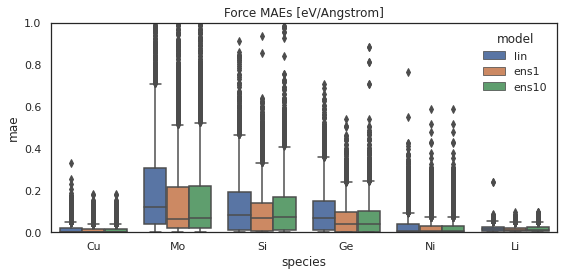

In [124]:
plt.figure(figsize = (8, 4))
sns.boxplot(data = df_f, x = 'species', y = 'mae', hue = 'model')
# plt.yscale('log')
plt.ylim(0, 1)
plt.legend(frameon=False, bbox_to_anchor = (1, 1), title = 'model')
plt.title('Force MAEs [eV/Angstrom]')
plt.tight_layout()
plt.savefig("/home/claudio/postdoc/plots/zuo_ensamble_force_maes.pdf")

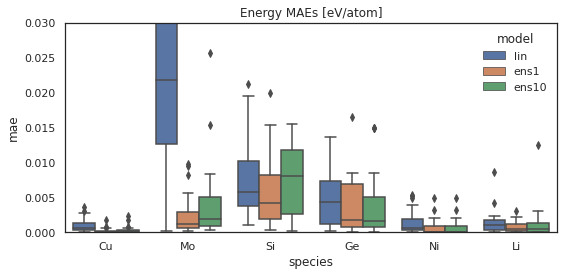

In [125]:
plt.figure(figsize = (8, 4))
sns.boxplot(data = df_en, x = 'species', y = 'mae', hue = 'model')
# plt.yscale('log')
plt.ylim(0, 0.03)
plt.legend(frameon=False, bbox_to_anchor = (1, 1), title = 'model')
plt.title('Energy MAEs [eV/atom]')
plt.tight_layout()
plt.savefig("/home/claudio/postdoc/plots/zuo_ensamble_energy_maes.pdf")

MAE=0.004 RMSE=0.008 SUP=0.009 R2=1.000
MAE=0.158 RMSE=0.261 SUP=1.417 R2=0.973


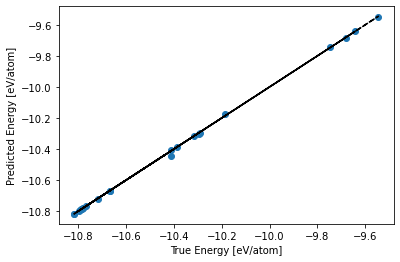

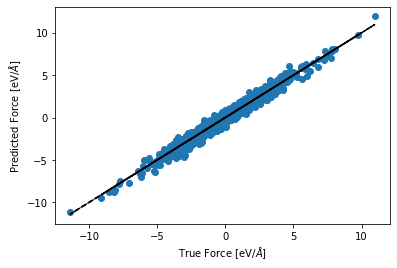

In [15]:
noise = 1e-8
n_clusters = 8
n_neighbours = 1
# train the model
model =  train_ensamble_linear_model(tr_features, noise, e_t, f_t,
                        n_neighbours=n_neighbours, 
                         n_clusters=n_clusters, clustering='e_gmm')

# evaluate its performances
ep = model.predict_energy(val_features)
fp = model.predict_forces(val_features)

print_score(ep/nat_val, e_val/nat_val)
print_score(fp.flatten(), f_val.flatten())
# print_score(vp.flatten(), s_val.flatten())

plt.scatter(e_val/nat_val, ep/nat_val)
plt.plot(e_val/nat_val, e_val/nat_val, 'k--')
plt.xlabel("True Energy [eV/atom]")
plt.ylabel("Predicted Energy [eV/atom]")
plt.show()

plt.scatter(f_val, fp)
plt.plot(f_val, f_val, 'k--')
plt.xlabel("True Force [eV/$\AA$]")
plt.ylabel("Predicted Force [eV/$\AA$]")
plt.show()

In [25]:
noise = 1e-8
model_lin = train_linear_model(tr_features, noise, e_t)

model_ens_1 =  train_ensamble_linear_model(tr_features, noise, e_t, f_t,
                        n_neighbours=1, 
                         n_clusters='auto', clustering='e_gmm')

model_ens_10 =  train_ensamble_linear_model(tr_features, noise, e_t, f_t,
                        n_neighbours=10, 
                         n_clusters='auto', clustering='e_gmm')

Using 9 clusters
Using 9 clusters


In [26]:
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase.md.verlet import VelocityVerlet
from ase import units
from ase import Atoms

In [32]:
atoms = Atoms(read(root + f"{species}/" + "validation_trajectory.xyz", index = 0))
calc = ASEMLCalculator(model_ens_10, model_ens_10.representation)
atoms.set_calculator(calc)

# Set the momenta corresponding to T=300K
MaxwellBoltzmannDistribution(atoms, temperature_K=10000)

# We want to run MD with constant energy using the VelocityVerlet algorithm.
dyn = VelocityVerlet(atoms, 3 * units.fs)  # 5 fs time step.

def printenergy(a):
    """Function to print the potential, kinetic and total energy"""
    epot = a.get_potential_energy() / len(a)
    ekin = a.get_kinetic_energy() / len(a)
    print('Energy per atom: Epot = %.3feV  Ekin = %.3feV (T=%3.0fK)  '
          'Etot = %.3feV' % (epot, ekin, ekin / (1.5 * units.kB), epot + ekin))


# Now run the dynamics
printenergy(atoms)
for i in range(2000):
    dyn.run(10)
    printenergy(atoms)

Energy per atom: Epot = -10.171eV  Ekin = 1.249eV (T=9661K)  Etot = -8.922eV
Energy per atom: Epot = -9.536eV  Ekin = 0.793eV (T=6137K)  Etot = -8.743eV
Energy per atom: Epot = -9.524eV  Ekin = 0.782eV (T=6051K)  Etot = -8.742eV
Energy per atom: Epot = -9.538eV  Ekin = 0.818eV (T=6326K)  Etot = -8.720eV
Energy per atom: Epot = -9.621eV  Ekin = 0.952eV (T=7364K)  Etot = -8.669eV
Energy per atom: Epot = -9.559eV  Ekin = 0.902eV (T=6979K)  Etot = -8.657eV
Energy per atom: Epot = -9.613eV  Ekin = 0.994eV (T=7692K)  Etot = -8.619eV
Energy per atom: Epot = -9.548eV  Ekin = 0.932eV (T=7214K)  Etot = -8.616eV
Energy per atom: Epot = -9.562eV  Ekin = 1.007eV (T=7789K)  Etot = -8.555eV
Energy per atom: Epot = -9.365eV  Ekin = 0.820eV (T=6342K)  Etot = -8.545eV
Energy per atom: Epot = -9.504eV  Ekin = 0.958eV (T=7411K)  Etot = -8.546eV
Energy per atom: Epot = -9.590eV  Ekin = 1.060eV (T=8204K)  Etot = -8.530eV
Energy per atom: Epot = -9.496eV  Ekin = 0.984eV (T=7615K)  Etot = -8.511eV
Energy per 

/home/claudio/postdoc/Castle/notebooks/../castle/lp_ensamble.py:119: RuntimeWarning: invalid value encountered in true_divide
  weights = np.exp(-neigh_dist)/np.sum(np.exp(-neigh_dist))
/home/claudio/postdoc/Castle/notebooks/../castle/lp_ensamble.py:169: RuntimeWarning: invalid value encountered in true_divide
  model_weights = np.exp(-neigh_dist)/np.sum(np.exp(-neigh_dist))
/home/claudio/postdoc/Castle/notebooks/../castle/lp_ensamble.py:181: RuntimeWarning: invalid value encountered in true_divide
  d_weights_d_descr /= np.sum(np.exp(-neigh_dist))
/home/claudio/.local/lib/python3.8/site-packages/ase/geometry/geometry.py:92: RuntimeWarning: invalid value encountered in remainder
  fractional[:, i] %= 1.0


ArithmeticError: <PyCall.jlwrap (in a Julia function called from Python)
JULIA: InexactError: trunc(Int64, NaN)
Stacktrace:
  [1] trunc
    @ ./float.jl:716 [inlined]
  [2] floor
    @ ./float.jl:294 [inlined]
  [3] #2
    @ ./broadcast.jl:314 [inlined]
  [4] macro expansion
    @ ~/.julia/packages/StaticArrays/OWJK7/src/broadcast.jl:126 [inlined]
  [5] _broadcast
    @ ~/.julia/packages/StaticArrays/OWJK7/src/broadcast.jl:100 [inlined]
  [6] copy
    @ ~/.julia/packages/StaticArrays/OWJK7/src/broadcast.jl:27 [inlined]
  [7] materialize
    @ ./broadcast.jl:883 [inlined]
  [8] position_to_cell_index
    @ ~/.julia/packages/NeighbourLists/OehCB/src/cell_list.jl:48 [inlined]
  [9] _celllist_(X::Vector{StaticArrays.SVector{3, Float64}}, cell::StaticArrays.SMatrix{3, 3, Float64, 9}, pbc::StaticArrays.SVector{3, Bool}, cutoff::Float64, TI::Type{Int64})
    @ NeighbourLists ~/.julia/packages/NeighbourLists/OehCB/src/cell_list.jl:126
 [10] _pairlist_(X::Vector{StaticArrays.SVector{3, Float64}}, cell::StaticArrays.SMatrix{3, 3, Float64, 9}, pbc::StaticArrays.SVector{3, Bool}, cutoff::Float64, TI::Type, fixcell::Bool)
    @ NeighbourLists ~/.julia/packages/NeighbourLists/OehCB/src/cell_list.jl:294
 [11] #PairList#1
    @ ~/.julia/packages/NeighbourLists/OehCB/src/cell_list.jl:6 [inlined]
 [12] neighbourlist(at::Atoms{Float64}, rcut::Float64; recompute::Bool, key::String, storelist::Bool, int_type::Type, kwargs::Base.Iterators.Pairs{Union{}, Union{}, Tuple{}, NamedTuple{(), Tuple{}}})
    @ JuLIP ~/.julia/packages/JuLIP/kvmr6/src/atoms.jl:198
 [13] neighbourlist
    @ ~/.julia/packages/JuLIP/kvmr6/src/atoms.jl:188 [inlined]
 [14] sum_descriptor(shipB::ACE.RPI.RPIBasis{Float64, ACE.RPI.BasicPSH1pBasis{Float64, 1, ACE.OrthPolys.TransformedPolys{Float64, ACE.Transforms.PolyTransform{Int64, Float64}, ACE.OrthPolys.OrthPolyBasis{Float64}}}, 1, ACE.DAGEvaluator}, at::Atoms{Float64})
    @ Main ~/postdoc/Castle/castle/julia_utils.jl:41
 [15] extract_info_frame(B::ACE.RPI.RPIBasis{Float64, ACE.RPI.BasicPSH1pBasis{Float64, 1, ACE.OrthPolys.TransformedPolys{Float64, ACE.Transforms.PolyTransform{Int64, Float64}, ACE.OrthPolys.OrthPolyBasis{Float64}}}, 1, ACE.DAGEvaluator}, frame::Atoms{Float64})
    @ Main ~/postdoc/Castle/castle/julia_utils.jl:144
 [16] invokelatest(::Any, ::Any, ::Vararg{Any, N} where N; kwargs::Base.Iterators.Pairs{Union{}, Union{}, Tuple{}, NamedTuple{(), Tuple{}}})
    @ Base ./essentials.jl:708
 [17] invokelatest(::Any, ::Any, ::Vararg{Any, N} where N)
    @ Base ./essentials.jl:706
 [18] _pyjlwrap_call(f::Function, args_::Ptr{PyCall.PyObject_struct}, kw_::Ptr{PyCall.PyObject_struct})
    @ PyCall ~/.julia/packages/PyCall/3fwVL/src/callback.jl:28
 [19] pyjlwrap_call(self_::Ptr{PyCall.PyObject_struct}, args_::Ptr{PyCall.PyObject_struct}, kw_::Ptr{PyCall.PyObject_struct})
    @ PyCall ~/.julia/packages/PyCall/3fwVL/src/callback.jl:44>